<a href="https://colab.research.google.com/github/teddy-teem/deep-learning/blob/master/CNN_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
torch.manual_seed(42)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/Datasets/dataset-MNIST-fashion/mnist_fashion_train.csv'


Mounted at /content/drive


In [5]:
df = pd.read_csv(file_path)
df.shape

(60000, 785)

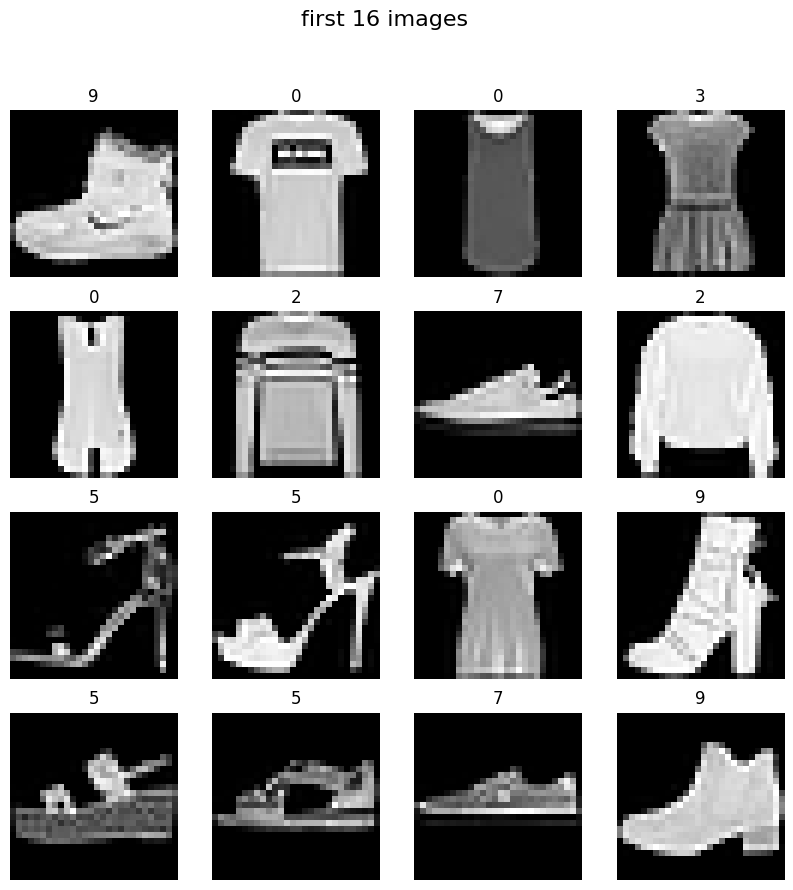

In [6]:
fig, axes = plt.subplots(4,4, figsize=(10, 10))
fig.suptitle("first 16 images", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28,28)
    ax.axis('off')
    ax.set_title(df.iloc[i, 0])
    ax.imshow(img, cmap='gray')

plt.show()

In [7]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# For better tuning, the pixel value should be between 0 to 1 that why we devided by 255 each
X_train = X_train / 255.0
X_test = X_test / 255.0

In [15]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features =torch.tensor(features, dtype=torch.float32).reshape(-1 ,1, 28, 28)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return len(self.features)

In [16]:
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True) # pin_memory=True to speed up the process
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [63]:
class MyNN(nn.Module):
    def __init__(self, input_features):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d( 64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 3 * 3, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 10)

        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [64]:
epochs = 100
learning_rate = 0.01

In [65]:
model = MyNN(1)
model.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [66]:
model

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momen

In [67]:
for epoch in range(epochs):
  total_epoch_loss = 0
  for batch_features, batch_labels in train_loader:
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)
    out = model(batch_features)
    loss = criterion(out, batch_labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss += loss.item()

  print(f"Epoch {epoch+1}, Loss: {total_epoch_loss/len(train_loader)}")


Epoch 1, Loss: 0.7521523825029532
Epoch 2, Loss: 0.4414077268689871
Epoch 3, Loss: 0.37164696330328784
Epoch 4, Loss: 0.33251940350731213
Epoch 5, Loss: 0.30365302532166244
Epoch 6, Loss: 0.28286253368109465
Epoch 7, Loss: 0.261828955916067
Epoch 8, Loss: 0.2424155255953471
Epoch 9, Loss: 0.23061774411797523
Epoch 10, Loss: 0.21826549580072363
Epoch 11, Loss: 0.20667899081048866
Epoch 12, Loss: 0.19624658811775347
Epoch 13, Loss: 0.18367122802510857
Epoch 14, Loss: 0.17343334548858305
Epoch 15, Loss: 0.16815867106368143
Epoch 16, Loss: 0.15587630137242378
Epoch 17, Loss: 0.1482697133210798
Epoch 18, Loss: 0.14354944739180306
Epoch 19, Loss: 0.13221868423496683
Epoch 20, Loss: 0.1257501575301091
Epoch 21, Loss: 0.12068867204803974
Epoch 22, Loss: 0.11451928192408134
Epoch 23, Loss: 0.11039255501702427
Epoch 24, Loss: 0.10527807289206734
Epoch 25, Loss: 0.10292449505316714
Epoch 26, Loss: 0.0997892547606801
Epoch 27, Loss: 0.09116210643776382
Epoch 28, Loss: 0.08867695040705924
Epoch 29,

In [68]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1152, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momen

In [69]:
len(test_loader)

375

In [70]:
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in test_loader:
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)
    out = model(batch_features)
    _, predicted = torch.max(out.data, 1)
    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

print(f"Test Accuracy: {100 * correct / total}%")

Test Accuracy: 92.475%


In [71]:
total = 0
correct = 0

with torch.no_grad():
  for batch_features, batch_labels in train_loader:
    batch_features = batch_features.to(device)
    batch_labels = batch_labels.to(device)
    out = model(batch_features)
    _, predicted = torch.max(out.data, 1)
    total += batch_labels.shape[0]
    correct += (predicted == batch_labels).sum().item()

print(f"Train Accuracy: {100 * correct / total}%")

Train Accuracy: 99.99375%
